In [189]:
import json
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input,Conv1D,MaxPool1D,LSTM,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

In [175]:
!wget https://github.com/Yossioren/pp0/master/occupancy_small.npz

--2021-03-03 20:51:43--  https://github.com/Yossioren/pp0/master/occupancy_small.npz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-03-03 20:51:43 ERROR 404: Not Found.



In [89]:
def cnn_lstm(input_vector, output_size=20, filters=256, strides=3, pool_size=4, units=32, dropout=0.7, lr=0.001)->tf.keras.Model:
    inp = Input((input_vector, 1))
    x = Conv1D( filters, kernel_size=16, strides=strides, activation='relu')(inp)
    x = MaxPool1D(pool_size=pool_size, padding='same')(x)
    x = Conv1D(filters, kernel_size=8, strides=strides, activation='relu', padding='same')(x)
    x = MaxPool1D(pool_size=pool_size, padding='same')(x)
    x = LSTM(units, return_sequences=True, recurrent_activation='hard_sigmoid')(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    preds = Dense(output_size, activation='softmax')(x)
    model = Model(inputs=inp, outputs=preds)
    opt = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # optimizer, metrics
    return model

In [90]:
def small_cnn_lstm(input_vector, output_size=20, filters=256, strides=3, pool_size=4, units=32, dropout=0.7, kernel_size=32, lr=0.001):
    inp = Input((input_vector, 1))
    x = Conv1D(filters, kernel_size=kernel_size, strides=strides, activation='relu')(inp)
    x = MaxPool1D(pool_size=pool_size, padding='same')(x)
    x = LSTM(units, return_sequences=True, recurrent_activation='hard_sigmoid')(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    preds = Dense(output_size, activation='softmax')(x)
    model = Model(inputs=inp, outputs=preds)
    opt = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # optimizer, metrics
    return model


In [200]:
def classify(dataset,n_validation=1):
    X=np.array( dataset['X'],dtype=np.float32)
    X=X.reshape(*X.shape,-1)
    y=np.array( dataset['y'])

    lab_enc=LabelEncoder()
    lab_hot=OneHotEncoder()
    y_num= lab_enc.fit_transform(y)
    y_hot=lab_hot.fit_transform(y_num.reshape(-1,1))
    y_hot=y_hot.toarray()

    skf = StratifiedShuffleSplit(n_splits=10,random_state=666)
    preds=[]
    true=[]
    counter=0
    for train_index, test_index in skf.split(X, y_num):
        if counter>=n_validation:
            break
        else:
            counter+=1
        X_train, X_test = X[train_index], X[test_index]
        mean=X_train.mean()
        std=X_train.std()
        X_train_norm=(X_train-mean+1e-10)/std
        X_test_norm=(X_test-mean+1e-10)/std

        y_train, y_test = y_hot[train_index], y_num[test_index]
        length=X_train.shape[1]
        if length<1000:
            model=small_cnn_lstm(X_train.shape[1])
        else:
            model=cnn_lstm(X_train.shape[1])
        model.fit(X_train_norm,y_train,validation_split=0.1,epochs=100,verbose=2,callbacks=[EarlyStopping( patience=2,restore_best_weights=True)])
        preds.extend( model.predict(X_test_norm).argmax(axis=-1))
        true.extend(y_test)
        
    print(classification_report(true, preds))
    cm = confusion_matrix(true,preds)
    fig,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,ax=ax)
    plt.show()



    

In [201]:
cache_occupancy_data='default_small.npz'
sweeps_data='sweeps_small.npz'
sns_data='sns_small.npz'
dns_data='dns_small.npz'

In [202]:
path=sweeps_data

In [203]:
data=np.load(path)

Train on 1620 samples, validate on 180 samples
Epoch 1/2
1620/1620 - 3s - loss: 2.8725 - accuracy: 0.1290 - val_loss: 2.4829 - val_accuracy: 0.2167
Epoch 2/2
1620/1620 - 2s - loss: 2.2613 - accuracy: 0.2735 - val_loss: 1.5801 - val_accuracy: 0.6444
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.78      0.70      0.74        10
           2       0.67      0.80      0.73        10
           3       0.44      0.80      0.57        10
           4       0.57      0.80      0.67        10
           5       0.67      0.20      0.31        10
           6       0.57      0.80      0.67        10
           7       0.50      0.20      0.29        10
           8       0.33      0.10      0.15        10
           9       1.00      0.10      0.18        10
          10       0.55      0.60      0.57        10
          11       0.25      0.10      0.14        10
          12       0.75      0.90      0.82     

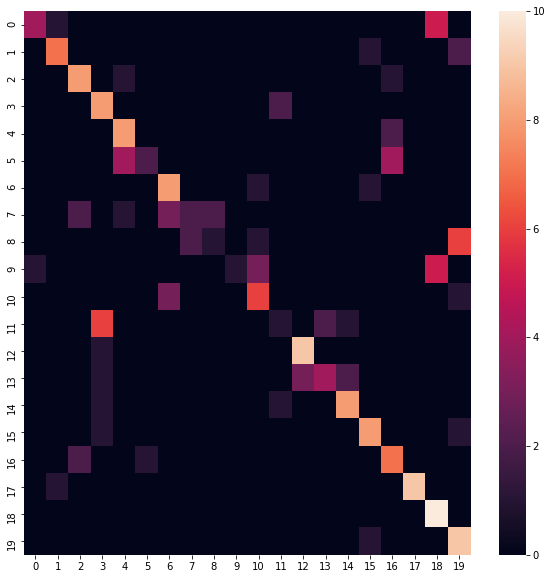

In [204]:
classify(data)